In [45]:
#%load_ext line_profiler

import matplotlib.pyplot as plt
import numpy as np
import tools

min_nscale = -1.0         # -0.6
max_nscale = 1.0          # 0.6
Nscale_points = 21

# dex = dB / 10
# 6am x 7nscale
# Make usable for analysis: verify for full range of cases (not just 50 but also 25 and 75) 
# Verify errors look just as small for these values too
# Develop interface to extract information: Instead of a bunch of methods but rather an object as a container
#   Carry the grid of values, set the nscale/zenith value, spit out tB spectrum, jacobian, and other things

ZA_points = 11
min_airmass = 1.001
max_airmass = 4.001
freq_points = 240001

Nscale_map = np.linspace(min_nscale, max_nscale, Nscale_points)
airmass_map = np.linspace(min_airmass, max_airmass, ZA_points)
za_map = tools.calc_zenith(airmass_map)

Tb_scalar_field = np.zeros((Nscale_points, ZA_points, freq_points))
Nscale_jacobian = np.zeros((Nscale_points, ZA_points, freq_points))
za_jacobian = np.zeros((Nscale_points, ZA_points, freq_points))
airmass_jacobian = np.zeros((Nscale_points, ZA_points, freq_points))

# Load interpolation & jacobian data
for idx, Nscale in enumerate(Nscale_map):
    for jdx, airmass in enumerate(airmass_map):

        filename = f'MaunaKea_Tb_Spectrum_{airmass:.3f}_{Nscale:.2f}'
        #data = np.load(f'/Users/gkeating/newdata/{filename}.out')
        #data = np.load(f'/Users/namsonnguyen/repo/AM_Data/Nscale21_AirMass11/{filename}.out')
        data = np.load(f'/Users/namsonnguyen/repo/AM_Data/MaunaKea_SON50/Nscale21_AirMass11/{filename}.out')

        freq_map = data[:,0]
        
        # Second column is Tb in K
        Tb_scalar_field[idx,jdx] = data[:,2]

        # Jacobian
        Nscale_jacobian[idx,jdx] = data[:,4] * (np.log(10) * (10 ** Nscale))
        za_jacobian[idx, jdx] = data[:,3]
        airmass_jacobian[idx,jdx] = za_jacobian[idx, jdx] / (airmass * np.sqrt((airmass**2) - 1))


# Compact data into passable dictionary
data_dict = tools.dictionarify(
    Nscale_points=Nscale_points,
    Nscale_map=Nscale_map,
    Nscale_jacobian=Nscale_jacobian,
    airmass_points=ZA_points,
    airmass_map=airmass_map,
    airmass_jacobian=airmass_jacobian,
    freq_points=freq_points,
    freq_map=freq_map,
    Tb_scalar_field=Tb_scalar_field
)

eval_grid = tools.DD_CubicHermiteSpline(
    eval_airmass=data_dict['airmass']['map'],
    eval_nscale=data_dict['Nscale']['map'],
    data_dict=data_dict,
    reverse=False
)

comparison_grid = ((eval_grid - Tb_scalar_field) / Tb_scalar_field) * 100

(180.0, 420.0)

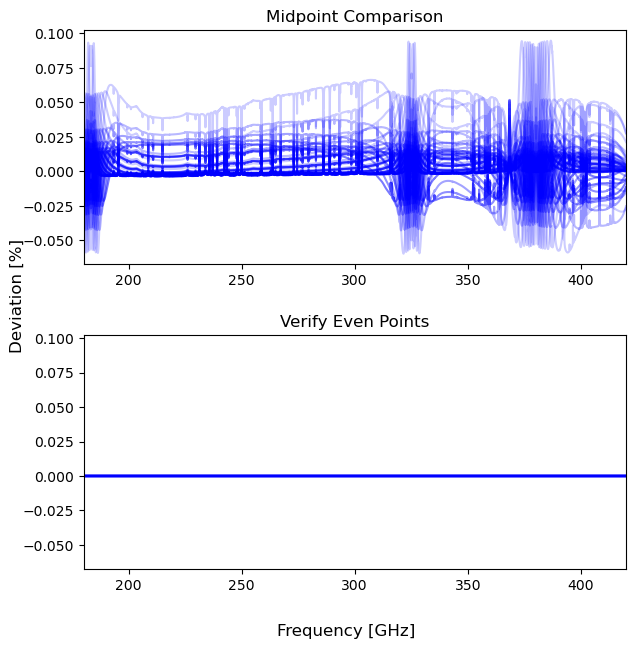

In [23]:
# Plot results
import matplotlib.colors as mcolors

fig, (ax1, ax2) = plt.subplots(2, 1, sharey=True, figsize=(7, 7))
plt.subplots_adjust(wspace=0.4, hspace=0.3)

freq_channels = np.linspace(180, 420, freq_points)
for idx in range(1, Nscale_points, 2):
    for jdx, color_alpha in zip(range(1, ZA_points, 2), np.linspace(0.2, 1, ZA_points)):
        color = mcolors.to_rgba('blue', alpha=color_alpha)
        ax1.plot(freq_channels, comparison_grid[idx,jdx], color=color)

fig.supylabel("Deviation [%]")
fig.supxlabel("Frequency [GHz]")

ax1.set_title("Midpoint Comparison")
#ax1.set_ylim(-50, 50)
ax1.set_xlim(180, 420)

freq_channels = np.linspace(180, 420, freq_points)
for idx in range(0, Nscale_points, 2):
    for jdx, color_alpha in zip(range(0, ZA_points, 2), np.linspace(0, 1, ZA_points)):
        color = mcolors.to_rgba('blue', alpha=color_alpha)
        ax2.plot(freq_channels, comparison_grid[idx,jdx], color=color)

ax2.set_title("Verify Even Points")
ax2.set_xlim(180, 420)

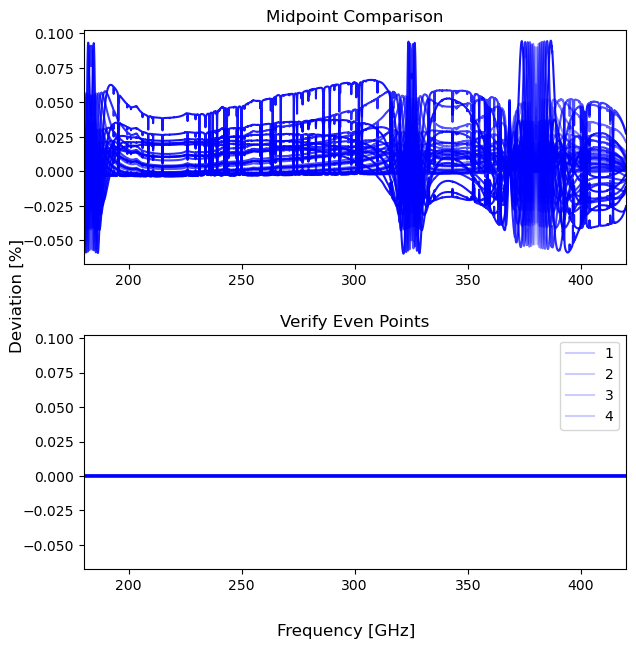

In [29]:
fig, (ax1, ax2) = plt.subplots(2, 1, sharey=True, figsize=(7, 7))
plt.subplots_adjust(wspace=0.4, hspace=0.3)

freq_channels = np.linspace(180, 420, freq_points)
for idx, color_alpha in zip(range(1, Nscale_points, 2), np.linspace(0.2, 1, ZA_points)):
    color = mcolors.to_rgba('blue', alpha=color_alpha)
    for jdx in range(1, ZA_points, 2):
        ax1.plot(freq_channels, comparison_grid[idx,jdx], color=color)

fig.supylabel("Deviation [%]")
fig.supxlabel("Frequency [GHz]")

ax1.set_title("Midpoint Comparison")
#ax1.set_ylim(-50, 50)
ax1.set_xlim(180, 420)

freq_channels = np.linspace(180, 420, freq_points)
for idx, color_alpha in zip(range(0, Nscale_points, 2), np.linspace(0.2, 1, ZA_points)):
    color = mcolors.to_rgba('blue', alpha=color_alpha)
    for jdx in range(0, ZA_points, 2):
        ax2.plot(freq_channels, comparison_grid[idx,jdx], color=color)

ax2.set_title("Verify Even Points")
ax2.set_xlim(180, 420)

numpy.ndarray

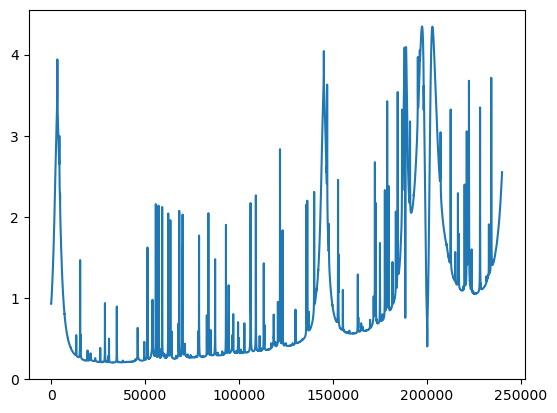

In [7]:
plt.plot(za_jacobian[0, 0])

Text(0.5, 1.0, 'Compare Interpolation Order of Operation')

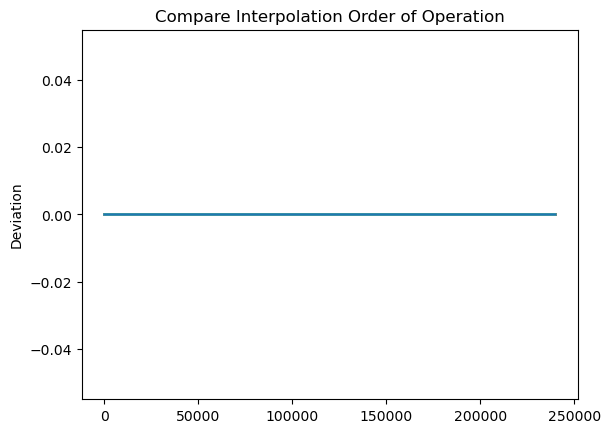

In [13]:
eval_grid_true = tools.DD_CubicHermiteSpline(
    eval_airmass=data_dict['airmass']['map'],
    eval_nscale=data_dict['Nscale']['map'],
    data_dict=data_dict,
    reverse=True,
)

comparison_grid_true = ((eval_grid_true - Tb_scalar_field) / Tb_scalar_field) * 100

eval_grid_false = eval_grid = tools.DD_CubicHermiteSpline(
    eval_airmass=data_dict['airmass']['map'],
    eval_nscale=data_dict['Nscale']['map'],
    data_dict=data_dict,
    reverse=False,
)

comparison_grid_false = ((eval_grid_true - Tb_scalar_field) / Tb_scalar_field) * 100

comparison_grid_true_false = comparison_grid_false - comparison_grid_false

for idx in range(0, Nscale_points):
    for jdx in range(0, ZA_points):
        plt.plot(comparison_grid_true_false[idx,jdx])

plt.ylabel("Deviation")
plt.title("Compare Interpolation Order of Operation")

In [ ]:
eval_grid = tools.DD_CubicHermiteSpline(
    eval_airmass=[1],
    eval_nscale=[1],
    data_dict=data_dict,
    reverse=False
)